### Steve's variable lag 

In [79]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

# standard library imports
import random
import math
from pathlib import Path
from typing import Tuple, List, Union, Optional, Sequence

# data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic

# machine learning imports
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape
from darts.models import BlockRNNModel
import torch
from torch.optim import AdamW
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger

# notebook imports
import ipywidgets as widgets
from IPython.display import display

# pandas settings
pd.set_option("display.max_columns", 50)

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(seed)

42

The following imports and setttings  
  
import logging  
import warnings  
logging.disable(logging.CRITICAL)  
warnings.filterwarnings("ignore")  
  
will disable this output:  
```
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | fc              | Sequential       | 130    | train
-------------------------------------------------------------

2.9 K     Trainable params  
0         Non-trainable params  
2.9 K     Total params  
0.012     Total estimated model params size (MB)  
8         Modules in train mode  
0         Modules in eval mode  
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch
```

In [ ]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [ ]:
SERIES_FIGSIZE = (20, 3)
SWITCH_PROB = 0.1
LAG_COLLAR = 8
TRAIN_SERIES_LEN = 4_000
INPUT_CHUNK_LEN = 200
OUTPUT_CHUNK_LEN = LAG_COLLAR

Create funtions for making and plotting p and q

In [ ]:
def create_scaled_random_array(n_values: int) -> np.ndarray:
    """
    Creates a random ndarray of shape (n_values, 1), scaled between 0 and 1.

    Parameters:
    n_values (int): The number of points in the array.

    Returns:
    numpy.ndarray: A scaled random ndarray with the first index set to 0.0.
    """
    random_values = np.random.uniform(-1, 1, n_values).astype(np.float32)
    random_values[0] = 0.0
    return random_values


def create_simple_lag_array(input_array: np.ndarray, lag: int) -> np.ndarray:
    """
    Creates a lagged version q of the input array.  The lag is a positive or negative integer.

    Parameters:
    input_array (numpy.ndarray): The input array.
    lag (int): The lag to apply.

    Returns:
    numpy.ndarray: The lagged array.
    """
    q = np.zeros_like(input_array).astype(np.float32)
    n_values = len(input_array)
    for i in range(n_values - 1):
        if i + lag < 0:
            q[i] = input_array[0]
        elif i + lag >= n_values - 1:
            q[i] = input_array[i - 1]
        else:
            q[i] = input_array[i + lag]
    return q


def Xcreate_variable_lag_array(
    input_array: np.ndarray, switch_prob: float
) -> Tuple[np.ndarray, List[int]]:
    """Create an array with variable time lags applied to the input array.

    This function generates a new array where each element is taken from the input array
    with a dynamically changing lag. The lag changes randomly based on the switch probability.
    lags can be positive or negative.

    Parameters
    ----------
    input_array : np.ndarray
        The input array to apply variable lags to
    switch_prob : float
        Probability (between 0 and 1) of changing the lag at each step

    Returns
    -------
    Tuple[np.ndarray, List[int]]
        - np.ndarray: Array of same shape as input with variable lags applied
        - List[int]: List of lags used at each position

    Notes
    -----
    - When lag causes index to go below 0, first element is used
    - When lag causes index to exceed array length, last element is used
    - Lag changes by +1 or -1 with equal probability when a switch occurs
    """
    lags = []
    n_values = len(input_array)
    q = np.zeros_like(input_array).astype(np.float32)

    # Generate q with variable lag
    lag = 0
    for i in range(n_values):
        if np.random.uniform(0, 1) < switch_prob:
            if np.random.uniform(0, 1) < 0.5:
                delta_lag = -1
            else:
                delta_lag = 1
            lag += delta_lag

        lags.append(lag)
        if i + lag < 0:
            q[i] = input_array[0]
        elif i + lag >= n_values - 1:
            q[i] = input_array[n_values - 1]
        else:
            q[i] = input_array[i + lag]
    print(f"Last value of input_array = {input_array[n_values - 1]}")
    return q, lags


def plot_simple_lag_p_q(p: np.ndarray, q: np.ndarray, title: str = "") -> None:
    """
    Plots p and q arrays with a simple lag.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    plt.plot(p, label="p", marker="o")
    plt.plot(q, label="q", marker="x")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_variable_lag_p_q(
    p_q: Union[tuple, TimeSeries], lags: List[int], title: str = ""
) -> None:
    """
    Plots p and q arrays with a variable lag.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    lags (List[int]): The list of lags.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """

    if isinstance(p_q, tuple):
        p: np.ndarray = p_q[0]
        q: np.ndarray = p_q[1]
    elif isinstance(p_q, TimeSeries):
        p: np.ndarray = p_q["p"].values()
        q: np.ndarray = p_q["q"].values()
    else:
        raise TypeError("Unsupported types for p_q")

    fig, (ax0, ax1) = plt.subplots(
        nrows=2,
        figsize=SERIES_FIGSIZE,
        gridspec_kw={"height_ratios": [3, 1]},
        sharex=True,
    )

    ax0.plot(p, label="p", marker="o")
    ax0.plot(q, label="q", marker="x")
    ax0.set_title("p and q")
    ax0.legend()

    ax1.bar(range(len(lags)), lags)
    ax1.set_title("lags")
    ax1.legend()

    fig.suptitle(title)
    plt.show()


def plot_variable_lag_pred_results(
    test_series: TimeSeries,
    test_lags: List[int],
    pred_series: TimeSeries,
    show_len: Optional[int] = None,
) -> None:
    """Plot test series with variable lags and predictions.

    Parameters
    ----------
    test_series : TimeSeries
        The test timeseries used in the prediction
    test_lags : List[int]
        List of lags corresponding to the test series
    pred_series : TimeSeries Note: only TimeSeries is supported for now
        Predicted series to plot against actuals. If None, only plots actuals
    show_len : Optional[int]
        Number of points to show in plot. If None, shows all points
    """
    # plot the test series with variable lags
    plot_variable_lag_p_q(test_series, test_lags, "test series with variable lags")

    # plot the test series (actuals only)
    if show_len is None:
        show_len = len(test_series)
    plt.figure(figsize=SERIES_FIGSIZE)
    test_series["p"][-show_len:-LAG_COLLAR].plot(label="actual_p", marker="o")
    test_series["q"][-show_len:-LAG_COLLAR].plot(label="actual_q", marker="x")

    # plot the prediction
    pred_series["p"].plot(label="predicted_p", marker="o", markersize=8)
    pred_series["q"].plot(label="predicted_q", marker="x", markersize=8)

    # Decorate the plot
    plt.title("Actual and Prediction")
    plt.legend()
    plt.show()

In [ ]:
# def create_variable_lag_array(
#     input_array: np.ndarray, switch_prob: float, lag_collar: int
# ) -> Tuple[np.ndarray, List[int]]:
#     """Create an array with variable time lags applied to the input array.

#     This function generates a lagged array "q" where each element is taken from the input array
#     with a dynamically changing lag. The lag changes randomly based on the switch probability.
#     lags can be positive or negative.

#     Parameters
#     ----------
#     input_array : np.ndarray
#         The input array to apply variable lags to
#     switch_prob : float
#         Probability (between 0 and 1) of changing the lag at each step
#     lag_collar : int
#         Maximum absolute value allowed for lag changes

#     Returns
#     -------
#     Tuple[np.ndarray, List[int]]
#         - np.ndarray: Array of same shape as input with variable lags applied
#         - List[int]: List of lags used at each position

#     Notes
#     -----
#     - When lag causes index to go below 0, first element is used
#     - When lag causes index to exceed array length, last element is used
#     - Lag changes by +1 or -1 with equal probability when a switch occurs
#     - Lag is constrained to stay within +/- lag_collar range
#     """
#     lags = []

#     # Add lag_collar number of values to the start of the input array.  value = extended_array[0]
#     # extended_array = np.concatenate(
#     #     (np.repeat(extended_array[0], lag_collar), extended_array)
#     # )
#     # # Add lag_collar number of values to the end of the input array.  value = extended_array[-1]
#     # extended_array = np.concatenate(
#     #     (extended_array, np.repeat(extended_array[-1], lag_collar))
#     # )
#     # ic(extended_array)
#     # return

#     n_values = len(input_array)
#     q = np.zeros_like(input_array).astype(np.float32)

#     # Generate q with variable lag
#     # lag = 1 # important for the start
#     lag = 0
#     for i in range(n_values):
#         if np.random.uniform(0, 1) < switch_prob:
#             if np.random.uniform(0, 1) < 0.5:
#                 delta_lag = -1
#             else:
#                 delta_lag = 1
#             if lag + delta_lag > lag_collar or lag + delta_lag < -lag_collar:
#                 delta_lag = -delta_lag # or should it be 0?
#             lag += delta_lag
#         # if i > 2:
#         #     lag = lag_collar

#         lag = 1

#         lags.append(lag)
#         if i + lag < 0:
#             q[i] = input_array[0]
#             print("bad q1")
#         elif i + lag > n_values - 1:
#             q[i] = input_array[n_values - 1]
#             print("bad q2")
#         else:
#             q[i] = input_array[i + lag]

#     return q, lags

In [6]:
def create_variable_neg_lag_array(
    input_array: np.ndarray, switch_prob: float, lag_collar: int
) -> Tuple[np.ndarray, List[int]]:
    """Create an array with only negative variable time lags applied to the input array.

    This function generates a lagged array "q" where each element is taken from the input array
    with a dynamically changing lag. The lag changes randomly based on the switch probability.
    lags can be positive or negative.

    Parameters
    ----------
    input_array : np.ndarray
        The input array to apply variable lags to
    switch_prob : float
        Probability (between 0 and 1) of changing the lag at each step
    lag_collar : int
        Maximum absolute value allowed for lag changes

    Returns
    -------
    Tuple[np.ndarray, List[int]]
        - np.ndarray: Array of same shape as input with variable lags applied
        - List[int]: List of lags used at each position

    Notes
    -----
    - When lag causes index to go below 0, first element is used
    - When lag causes index to exceed array length, last element is used
    - Lag changes by +1 or -1 with equal probability when a switch occurs
    - Lag is constrained to stay within +/- lag_collar range
    """
    lags = []

    n_values = len(input_array)
    q = np.zeros_like(input_array).astype(np.float32)

    # Generate q with variable lag
    lag = -1
    for i in range(n_values):
        if np.random.uniform(0, 1) < switch_prob:
            if np.random.uniform(0, 1) < 0.5:
                delta_lag = -1
            else:
                delta_lag = +1
            if lag + delta_lag > lag_collar or lag + delta_lag < -lag_collar:
                delta_lag = -delta_lag
            lag += delta_lag
            if lag > 0:
                lag = -1

        lags.append(lag)
        if i + lag < 0:
            q[i] = input_array[0]
            print("bad q case start")
        elif i + lag > n_values - 1:
            q[i] = input_array[n_values - 1]
            print("bad q case end")
        else:
            q[i] = input_array[i + lag]

    return q, lags


def create_variable_lag_array(
    input_array: np.ndarray, switch_prob: float, lag_collar: int
) -> Tuple[np.ndarray, List[int]]:
    return create_variable_neg_lag_array(input_array, switch_prob, lag_collar)

Show p and variable lag q with lags in a dataframe.

-1, bad q1
+1, bad q2

In [ ]:
# # np.random.seed(seed)
# p = np.array([v*10 for v in range(10)]).astype(np.float32)

# # p extension has to happen before the call to create_variable_lag_array()
# p = np.concatenate((np.repeat(p[0], 2), p))
# p = np.concatenate((p, np.repeat(p[-1], 2)))

# q, lags = create_variable_lag_array(p, switch_prob=0.1, lag_collar=2)

# # Chop has to happen after the call to create_variable_lag_array()
# p = p[2:-2]
# q = q[2:-2]
# lags = lags[2:-2]


# df = pd.DataFrame({"p": p, "q": q, "lags": lags})
# df = df.astype(int)
# df = df.T
# df

In [ ]:
# np.random.seed(seed)
p = np.array([v * 10 for v in range(10)]).astype(np.float32)
q, lags = create_variable_lag_array(p, switch_prob=0.1, lag_collar=2)

df = pd.DataFrame({"p": p, "q": q, "lags": lags})
df = df.astype(int)
df = df.T
df

bad q case start


,0,1,2,3,4,5,6,7,8,9
p,0,10,20,30,40,50,60,70,80,90
q,0,0,10,20,30,40,60,70,80,80
lags,-1,-1,-1,-1,-1,-1,0,0,0,-1


Plot p and variable lag q with lags

bad q case start


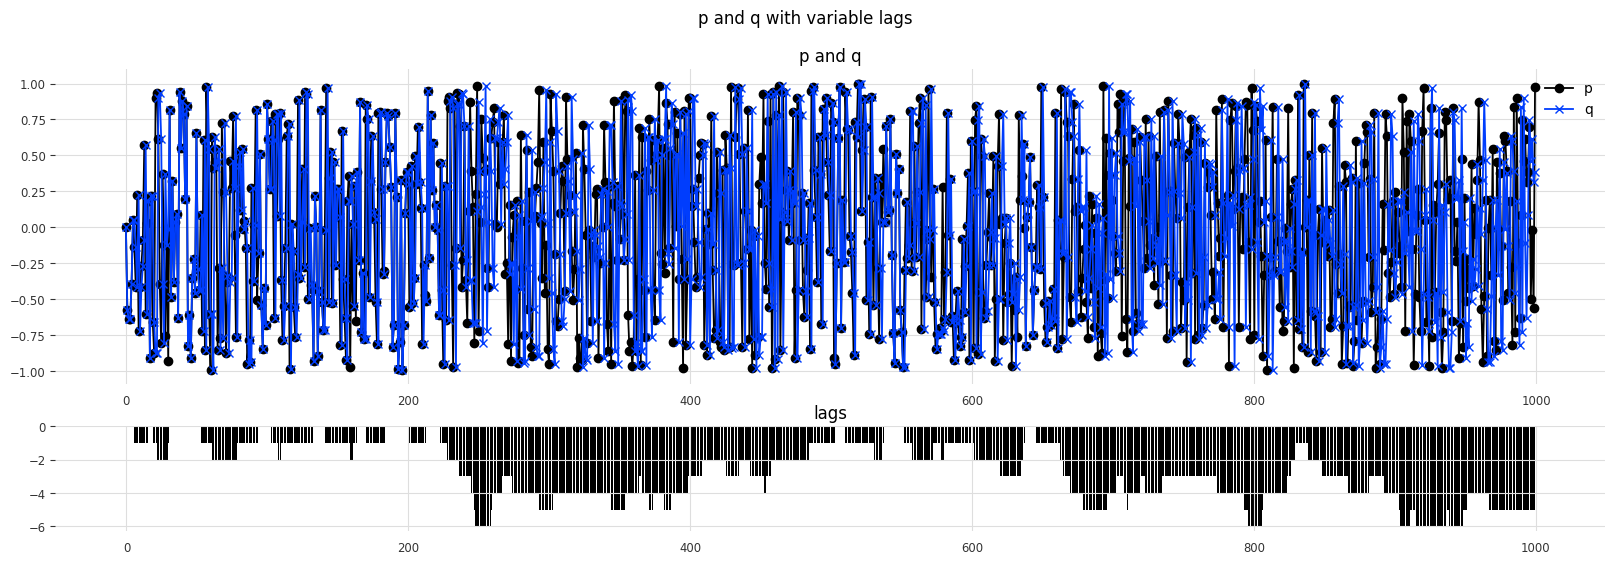

In [ ]:
p = create_scaled_random_array(n_values=1000)
q, lags = create_variable_lag_array(
    np.array(p), switch_prob=SWITCH_PROB, lag_collar=LAG_COLLAR
)
plot_variable_lag_p_q(
    (
        p,
        q,
    ),
    lags,
    "p and q with variable lags",
)

Function to make a TimeSeries of p and q pairs as components

In [ ]:
def create_variable_lag_p_q_series(
    n_values: int, switch_prob: float
) -> Tuple[TimeSeries, List[int]]:
    """
    Creates a TimeSeries with pairs of target (p) and variable lagged (q) time series
    as Darts TimeSeries objects.

    Parameters:
    n_values (int): The number of points in each time series.
    switch_prob (float): The probability of switching the lag.

    Returns:
    TimeSeries: A Darts TimeSeries object, containing a pair of p and lagged q time series.
    """

    p = create_scaled_random_array(n_values=n_values)
    q, lags = create_variable_lag_array(
        input_array=p, switch_prob=switch_prob, lag_collar=LAG_COLLAR
    )
    p_q_series = TimeSeries.from_values(values=p).stack(
        other=TimeSeries.from_values(values=q)
    )
    p_q_series = p_q_series.with_columns_renamed(
        col_names=["0", "0_1"], col_names_new=["p", "q"]
    )
    return p_q_series, lags

Create p_q_series  
Split into train and validation  
plot train and validation series

ic| n_examples: 3793
ic| max(lags): 0, min(lags): -8
ic| len

bad q case start


(train_series): 3792, len(val_series): 208


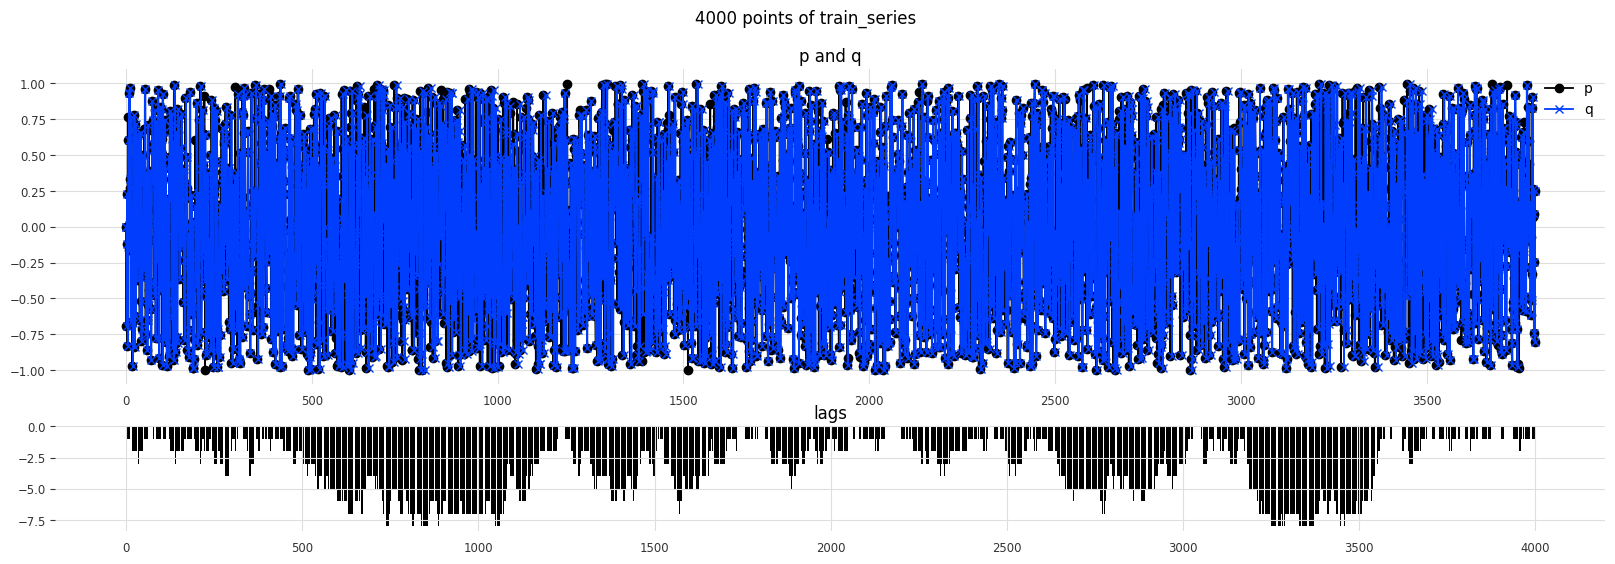

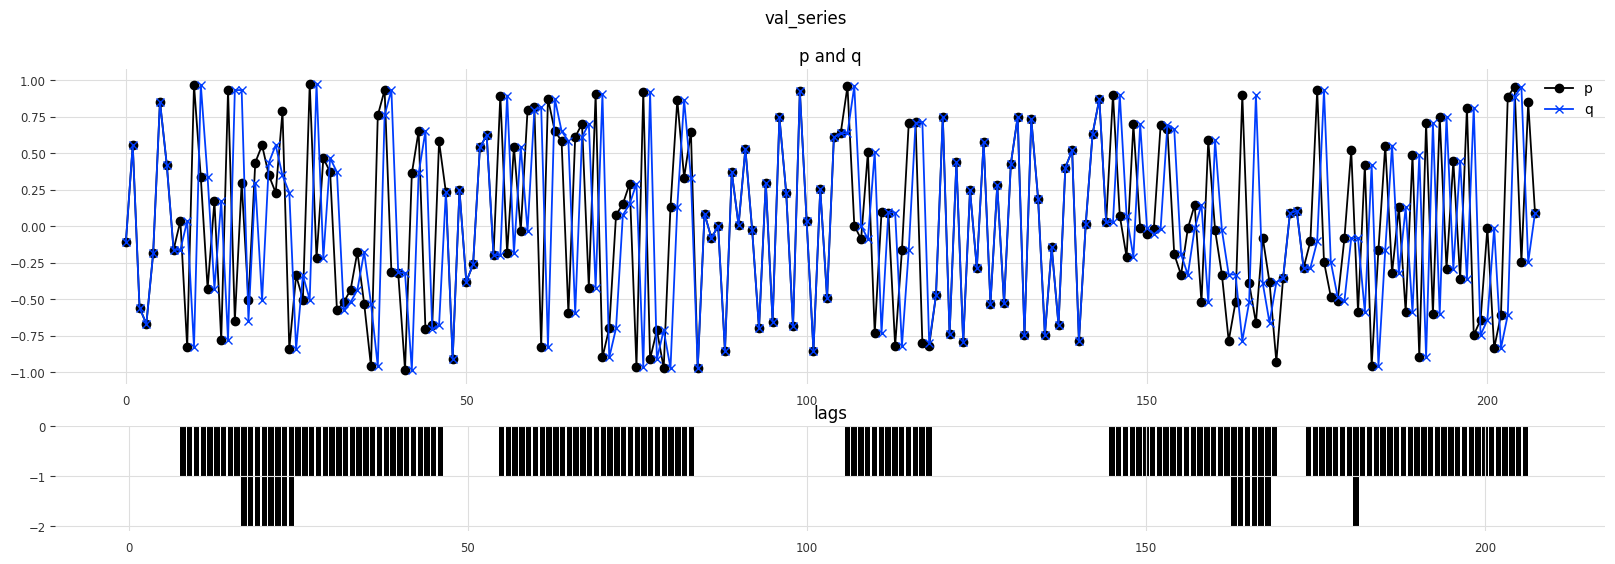

In [11]:
n_examples = TRAIN_SERIES_LEN - INPUT_CHUNK_LEN - OUTPUT_CHUNK_LEN + 1
ic(n_examples)

# Create  p_q series
p_q_series, lags = create_variable_lag_p_q_series(
    n_values=TRAIN_SERIES_LEN, switch_prob=0.1
)
ic(max(lags), min(lags))

# Split into train and validation series
val_series_len = INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN
train_series, val_series = p_q_series[:-val_series_len], p_q_series[-val_series_len:]
ic(len(train_series), len(val_series))

# Plot the end of the train series
# N_END_VALUES = 3800
# lags_end = lags[-N_END_VALUES:]
plot_variable_lag_p_q(
    p_q=train_series,
    lags=lags,
    title=f"{TRAIN_SERIES_LEN} points of train_series",
)

# Plot the validation series
plot_variable_lag_p_q(p_q=val_series, lags=lags[-val_series_len:], title="val_series")

Function(s) for models

Each checkpoint file will typically have a name like epoch=N-step=M.ckpt, where N is the epoch number and M is the training step number.

You can customize the checkpoint location by adding a ModelCheckpoint callback to the callbacks list in pl_trainer_kwargs, like this:

```
from pytorch_lightning.callbacks import ModelCheckpoint

pl_trainer_kwargs = {
    "accelerator": "cpu",
    "callbacks": [
        TFMProgressBar(enable_train_bar_only=True),
        ModelCheckpoint(
            dirpath="your/custom/path",
            filename="{epoch}-{step}",
            save_top_k=3
        )
    ],
    "logger": tensorboard_logger,
}
```

In [ ]:
LOG_DIR = r"/workspaces/darts/examples/darts_logs/variable_lag"


def create_BlockRNNModel(n_epochs, sub_dir="default"):
    tensorboard_logger = TensorBoardLogger(save_dir=LOG_DIR, name=sub_dir)
    pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }

    optimizer_kwargs = {"lr": 1e-3}
    return BlockRNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LEN,
        output_chunk_length=OUTPUT_CHUNK_LEN,
        n_epochs=n_epochs,
        batch_size=32,
        optimizer_kwargs=optimizer_kwargs,
        random_state=seed,
        log_tensorboard=True,
        model_name="variable_lag",
        pl_trainer_kwargs=pl_trainer_kwargs,
        hidden_dim=50,
        n_rnn_layers=2,
    )

In [ ]:
def greeting(name: str) -> None:
    print(f"Hello {name} from the variable_lag notebook!")


def confirm_greeting(name: str) -> None:
    confirm_button = widgets.Button(description="Confirm Greeting")
    output = widgets.Output()

    def on_button_clicked(b):
        # with output:
        greeting(name)

    confirm_button.on_click(on_button_clicked)
    display(confirm_button)  # , output)


confirm_greeting("Dave")

Button(description='Confirm Greeting', style=ButtonStyle())

In [ ]:
def greeting(name: str) -> None:
    print(f"Hello {name} from the variable_lag notebook!")


# Prompt the user for confirmation
confirm = input("Do you want to execute the greeting function? (yes/no): ")

if confirm.lower() == "yes":
    greeting("Dave")
else:
    print("Greeting function execution cancelled.")

Create the model

In [13]:
model = create_BlockRNNModel(n_epochs=900)

Training: 0it [00:00, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=50, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, input_chunk_length=200, output_chunk_length=8, n_epochs=900, batch_size=32, optimizer_kwargs={'lr': 0.001}, random_state=42, log_tensorboard=True, model_name=variable_lag, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7f1ff8491d80>], 'logger': <pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f21380f1cf0>})

In [ ]:
def confirm_execution():
    confirm_button = widgets.Button(description="Confirm Execution")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            # print("Fitting the model the code...")
            pass

    confirm_button.on_click(on_button_clicked)
    display(confirm_button, output)


confirm_execution()

Fit the model

In [ ]:
import ipywidgets as widgets
from IPython.display import display


def confirm_execution():
    confirm_button = widgets.Button(description="Confirm Execution")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            # print("Fitting the model the code...")
            model.fit(series=train_series, val_series=val_series)

    confirm_button.on_click(on_button_clicked)
    display(confirm_button, output)


confirm_execution()

Save the model

In [16]:
MODEL_SAVE_PATH = r"./darts_logs/variable_lag/model_save_900"
save_file_path = Path(MODEL_SAVE_PATH + "/model.pt")
save_file_path.parent.mkdir(parents=True, exist_ok=True)
model.save(str(save_file_path))

Plot the validation series and the prediction

In [ ]:
# TODO
# pred = model.predict(n=1, series=val_series[:INPUT_CHUNK_LEN])
# plot_variable_lag_p_q(val_series, val_lags, "val_series")
# pred.plot(label="forecast")
# plt.legend()

1. Create a test series
2. Make a prediction
3. Display prediction result plots

bad q case start


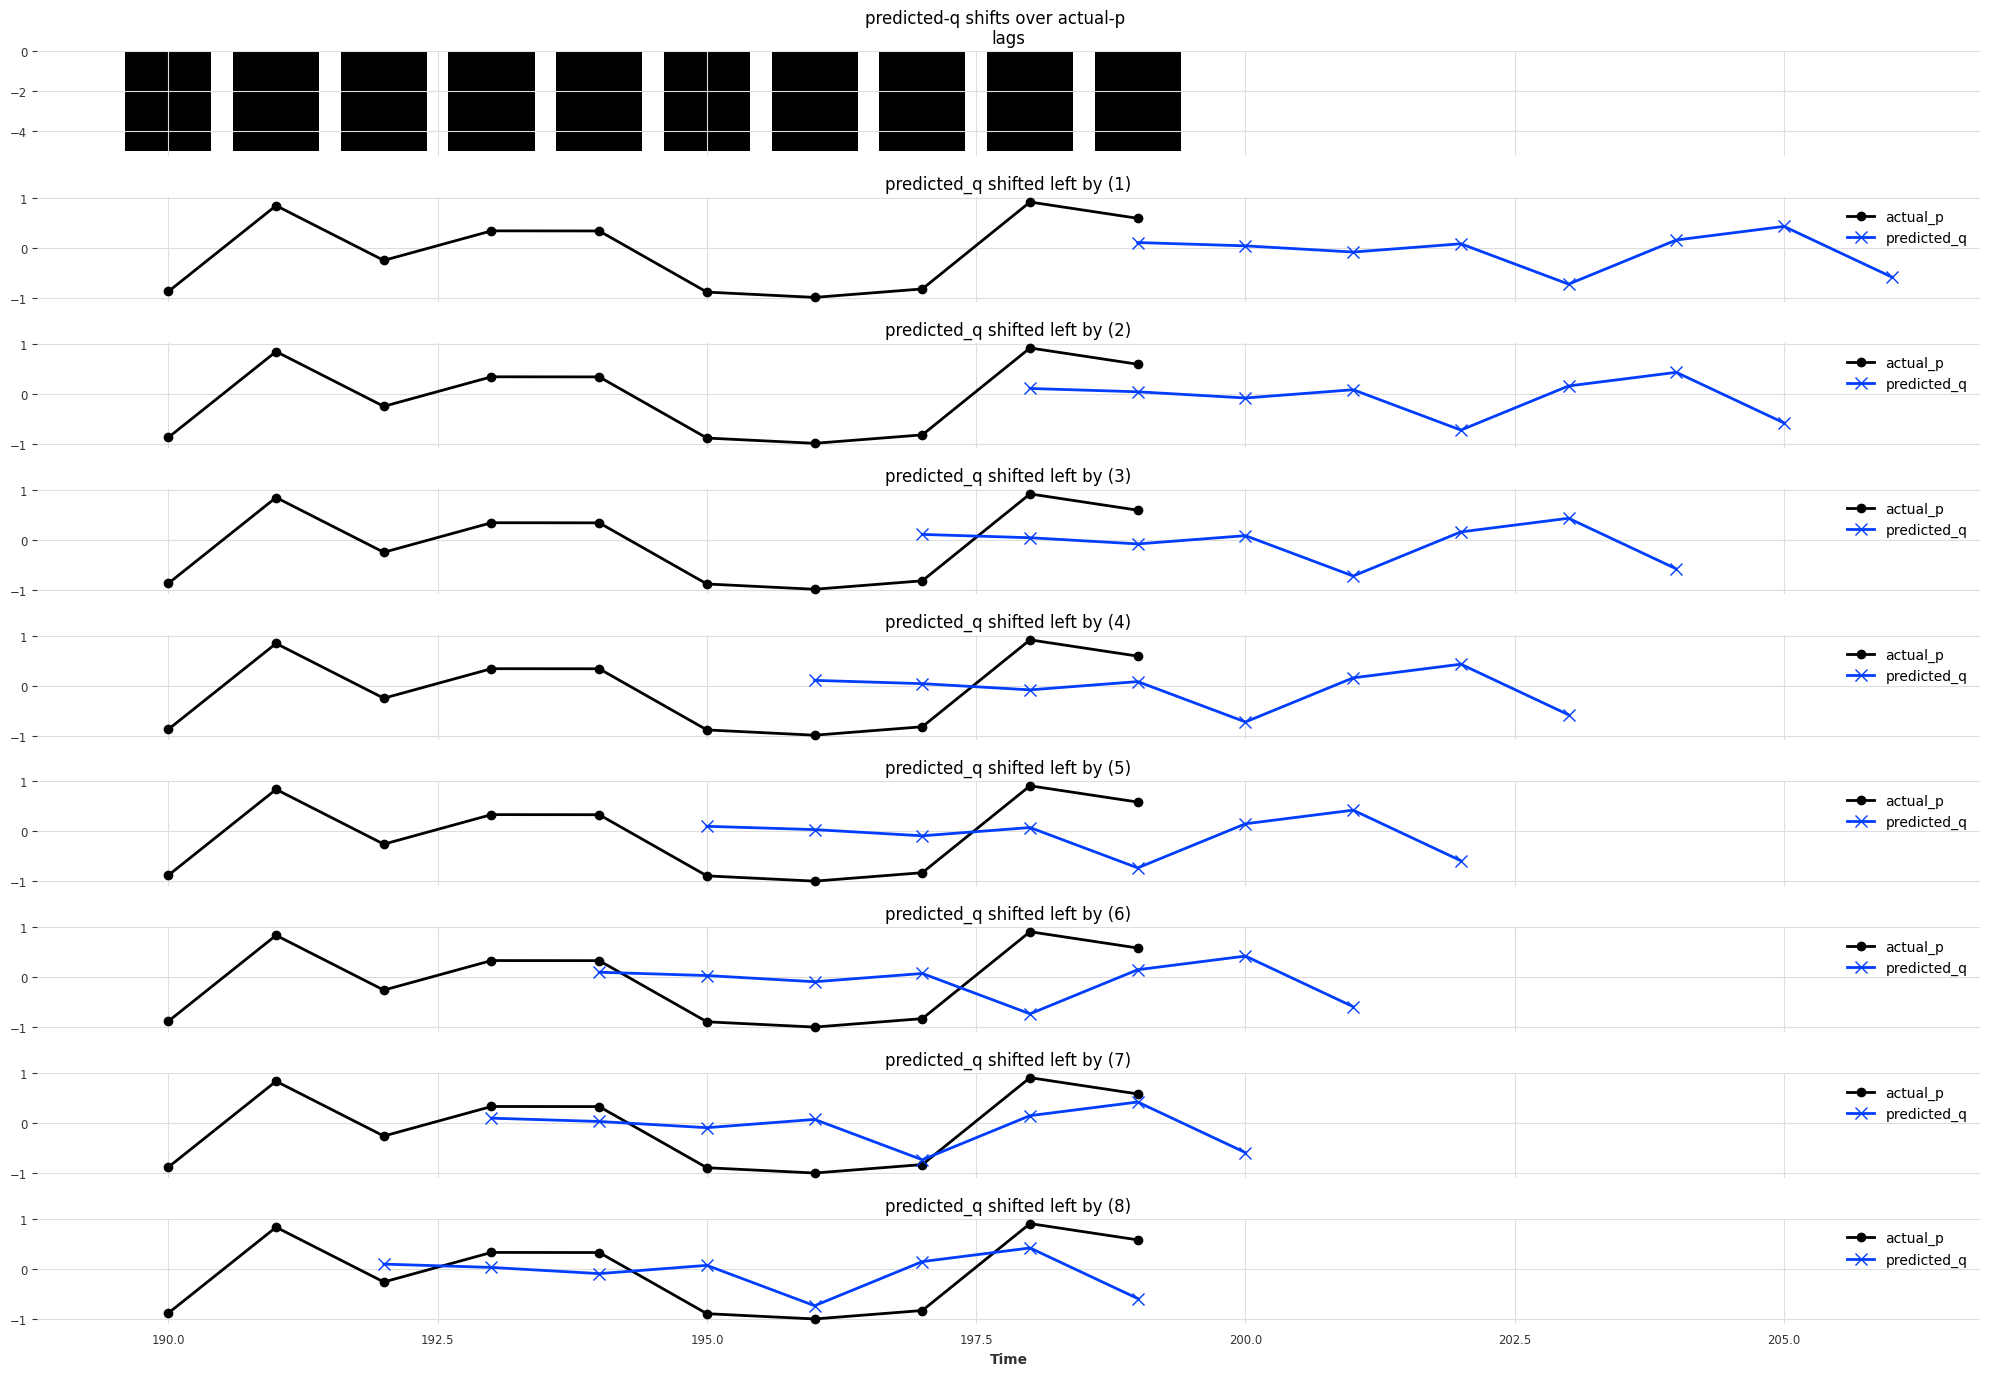

In [224]:
test_series_len = INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN
test_series, test_lags = create_variable_lag_p_q_series(
    n_values=test_series_len, switch_prob=SWITCH_PROB
)
pred_series = model.predict(n=LAG_COLLAR, series=test_series[:INPUT_CHUNK_LEN])

ic_end_len_display = (
    10  # The number of actual values at the end of the input chunk to show
)
display_start_idx = INPUT_CHUNK_LEN - ic_end_len_display
display_end_idx = INPUT_CHUNK_LEN
n_subplots = LAG_COLLAR + 1
fig, axes = plt.subplots(
    nrows=n_subplots,
    figsize=(20, 14),
    gridspec_kw={"height_ratios": [1 for i in range(n_subplots)]},
    sharex=True,
)

ax0 = axes[0]
ax0.bar(
    range(display_start_idx, display_end_idx),
    test_lags[display_start_idx:display_end_idx],
    align="center",
)
ax0.set_title("lags")
ax0.legend()

def doit(axes, shift):
    axes_idx = shift
    test_series["p"][display_start_idx:display_end_idx].plot(
        ax=axes[axes_idx], label="actual_p", marker="o"
    )
    pred_shifted = pred_series.shift(-shift)  # type: ignore
    pred_shifted["q"].plot(
        ax=axes[axes_idx], label="predicted_q", marker="x", markersize=8
    )
    axes[axes_idx].set_xlabel(None)
    axes[axes_idx].set_title(f"predicted_q shifted left by ({shift})")
    axes[axes_idx].legend()

for i in range(LAG_COLLAR):
    shift = i + 1
    doit(axes, shift)
axes[-1].set_xlabel("Time")

fig.suptitle("predicted-q shifts over actual-p")
plt.tight_layout()
plt.show()